# Proyecto Final 
------

Por Ramón Escobar para Ciencia de Datos en Python I (Abril 2021)

In [1]:
#Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
style.use('ggplot')

## Carga de datos y Train-Test Split

In [2]:
data = np.load('proyecto_training_data.npy', allow_pickle = False)

In [3]:
data.shape

(1460, 6)

In [4]:
pct_test = int(data.shape[0]*0.8)
pct_train = int(data.shape[0]*0.2)
np.random.shuffle(data)

train, test = data[:pct_test], data[:pct_train]
train.shape, test.shape

((1168, 6), (292, 6))

## Descriptivos de datos

In [5]:
train = pd.DataFrame(train, 
             columns = ['SalePrice', 'OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

test = pd.DataFrame(test, 
             columns = ['SalePrice','OverallQual', '1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

In [6]:
train.describe()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,960.000000
mean,180026.173801,6.091610,1165.037671,6.496575,1970.869863,69.645833
std,79876.841976,1.364628,387.139049,1.621404,30.507928,23.643370
min,34900.000000,1.000000,372.000000,3.000000,1872.000000,21.000000
25%,130000.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,160000.000000,6.000000,1092.000000,6.000000,1972.000000,69.000000
75%,210250.000000,7.000000,1392.000000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,12.000000,2010.000000,313.000000


## Histogramas

In [8]:
def hist_dimensions(data, dimension):
    plot = sns.displot(data = data, x = dimension)
    plt.title(dimension)
    plt.xlabel(dimension, fontsize = 12)
    plt.ylabel('Conteo', fontsize = 12)
    plt.show()

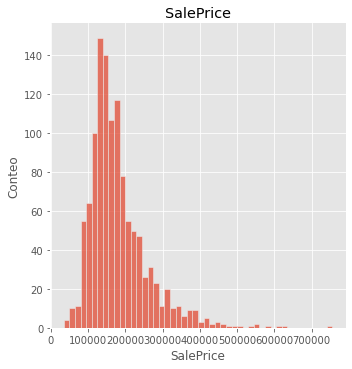

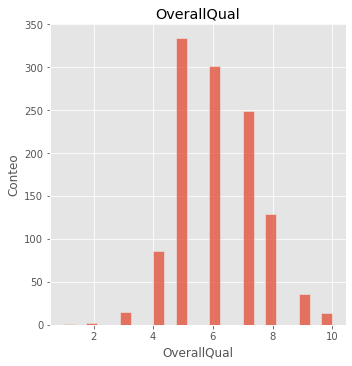

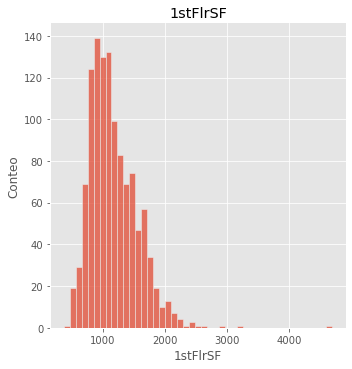

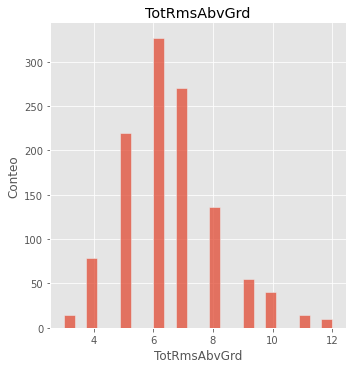

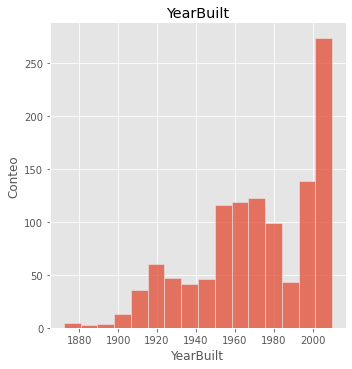

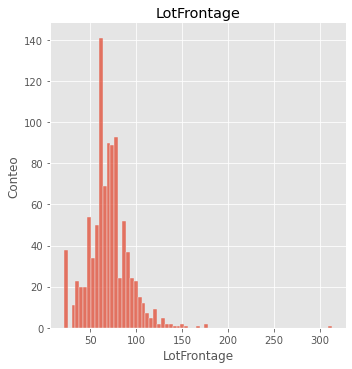

In [9]:
for i in train.columns.to_list():
    hist_dimensions(train, i)

## Correlaciones

In [36]:
def correlations_xy(data, x_dim, y_dim):
    corr = (pd.DataFrame(data[[x_dim, y_dim]]).corr().iloc[0,1])
    plt.figure(figsize = (6,3))
    plt.scatter(data = data, x = x_dim, y = y_dim)
    plt.title(str(x_dim)+' vs '+ str(y_dim) + ' | Corr:'+str((round(corr,4))), fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.show()
    return round(corr,4)

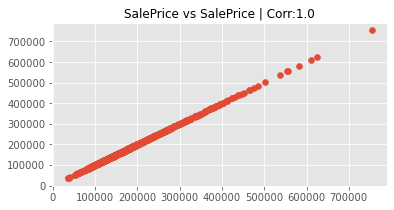

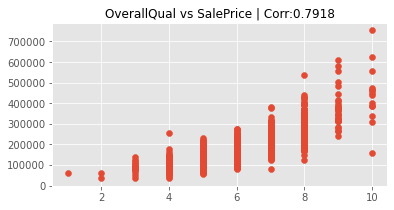

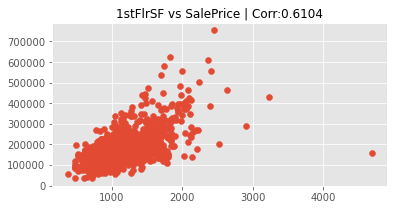

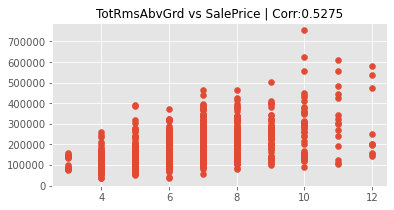

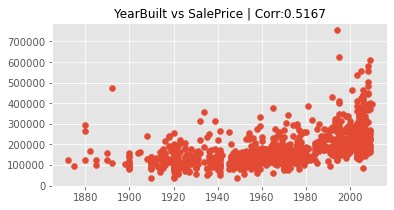

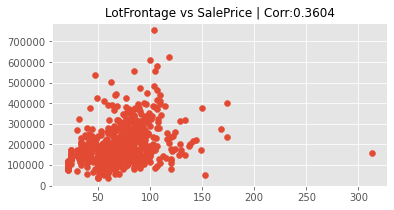

In [37]:
variables = []
correlations = []
for i in train.columns.to_list():
    variables.append(i)
    correlations.append(correlations_xy(train, i, 'SalePrice'))

In [31]:
top_corr_variables = pd.DataFrame({'Variables':variables, 
                                   'Correlaciones':correlations})

In [35]:
top_corr_variables.sort_values(by='Correlaciones', ascending = False)[1:3]

,Variables,Correlaciones
1,OverallQual,0.7918
2,1stFlrSF,0.6104


In [46]:
train_OverallQual = np.array(train['OverallQual']) 
train_1stFlrSF = np.array(train['1stFlrSF'])
train_SalePrice = np.array(train['SalePrice'])

Basado en esta información, OverallQual 1stFlrFS son las candidatas a ser las variables con mayor poder predictivo

## Regresión

In [38]:
class univ_linear_reg():
    def __init__(self, x, y, epochs = 1000, imprimir_error_cada=100, learning_rate = 0.001 ):
        self.x_original = x
        self.vect_ones = np.ones_like(x).reshape(-1,1)
        self.xr = np.reshape(x,(-1,1))
        self.xr = np.hstack([self.xr,self.vect_ones])
        self.yr = np.reshape(y, (-1,1))
        
        #inicializando betas
        self.b0 = 0
        self.b1 = 1
        self.betas = np.array([[self.b1],[self.b0]])
    
        #inicilizando almacenamiento de errores y modelo
        self.errors = []
        self.models = {}
        
        for i in range(0, epochs):
            #Predicciones
            self.y_pred = np.dot(self.xr, self.betas)

            #Calculo del error
            self.e = 1/(2*self.yr.shape[0]) * sum((self.yr - self.y_pred)**2)
            self.errors.append(self.e[0])

            #calculando gradientes
            self.gradient = 1/self.yr.shape[0]*sum((self.y_pred - self.yr)*self.xr)
            self.mult_gradient = (learning_rate*self.gradient)
            self.mult_gradient = self.mult_gradient.reshape((-1,1))

            #Actualizando Betas
            self.betas = self.betas - self.mult_gradient
            self.models[i] = [self.betas, self.y_pred, self.yr, self.x_original]

            #Imprimiendo resultados cada n veces
            if i%imprimir_error_cada==0:
                print('Iteración: ', i)
                print('Error: ',self.e[0])
                print("")
        
    def trained_models(self):
        return self.models , np.array(self.errors)
    
    def predictions(self, x_rp):
        self.vect_ones_xp = np.ones_like(x_rp).reshape(-1,1)
        self.xp = np.reshape(x_rp,(-1,1))
        self.xp = np.hstack([self.xp,self.vect_ones_xp])
        
        self.yp = np.dot(self.xp, self.betas)
        return self.yp

    @staticmethod
    def error_predictions(ypp, ypr):
        ep = 1/(2*ypp.shape[0]) * np.sum((ypr - ypp)**2)
        return ep
    
    @staticmethod
    def error_plot(errors):
        plt.figure(figsize = (7,3))
        plt.plot(errors)
        plt.title("Errores del modelo", fontsize = 12)
        plt.xlabel("Epoch", fontsize = 10)
        plt.ylabel("Errores")
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.show()
        
    @staticmethod
    def model_plot(models_t,n):
        for k in models_t.keys():
            if k%n == 0:
                plt.figure(figsize = (5,5))
                plt.scatter(x = models_t[k][3], y = models_t[k][2], color = '#CDCDCD')
                plt.plot(models_t[k][3],  models_t[k][1], linestyle ='solid', color ='b')
                plt.title("Modelo #"+str(k), fontsize = 12)
                plt.xlabel("X", fontsize = 10)
                plt.ylabel("Y", fontsize = 10)
                plt.xticks(fontsize = 10)
                plt.yticks(fontsize = 10)
                plt.show()
                
    @staticmethod
    def model_comparative(model1, model2 , x):
        #predicciones del modelo propio
        result_m1 = model1.predictions(x)
        
        #predicciones de sklearn
        result_m2 = model2.predict(x.reshape(-1,1))
        
        #promedio de ambos modelos
        avg_result = (result_m1 + result_m2)/2

        return result_m1, result_m2, avg_result
    
    @staticmethod
    def ploting_error_models(modelos):
        i = 0
        labels = []
        e_modelos = []
        for r in modelos:
            i +=1
            e_modelos.append(univ_linear_reg.error_predictions(r, np.array(test['SalePrice'])))
            labels.append('Modelo'+str(i) + '\n'+str(round(univ_linear_reg.error_predictions(r, np.array(test['SalePrice'])),0)))

        fig, ax = plt.subplots()
        ax.bar(labels, e_modelos)
        fig.tight_layout()
        plt.show()

## Entrenando modelos de regresión - con OverallQual

In [47]:
m1 = univ_linear_reg(train_OverallQual, 
                     train_SalePrice, 
                     15001,1500,0.001)
m1_modelos, m1_errores = m1.trained_models()    

Iteración:  0
Error:  19390952406.34503

Iteración:  1500
Error:  1426405355.0838144

Iteración:  3000
Error:  1395426212.3570924

Iteración:  4500
Error:  1368489471.9002187

Iteración:  6000
Error:  1345067649.2616262

Iteración:  7500
Error:  1324702090.3109438

Iteración:  9000
Error:  1306993989.7171717

Iteración:  10500
Error:  1291596581.4064763

Iteración:  12000
Error:  1278208348.0705094

Iteración:  13500
Error:  1266567116.751478

Iteración:  15000
Error:  1256444924.8817668



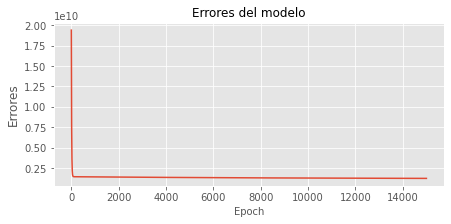

In [44]:
univ_linear_reg.error_plot(m1_errores)

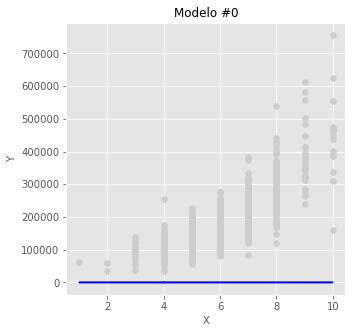

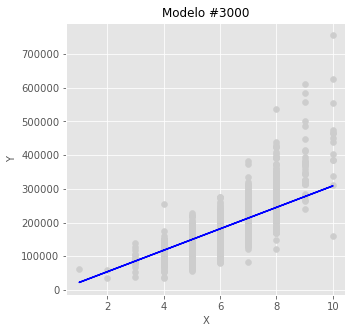

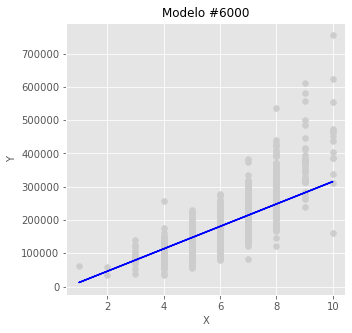

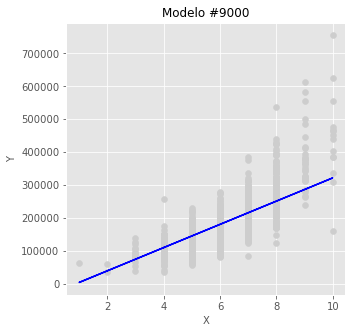

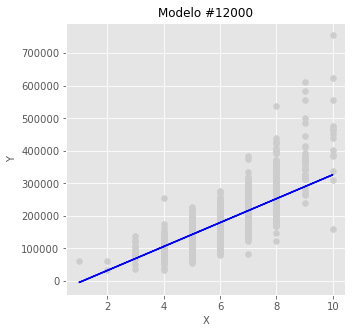

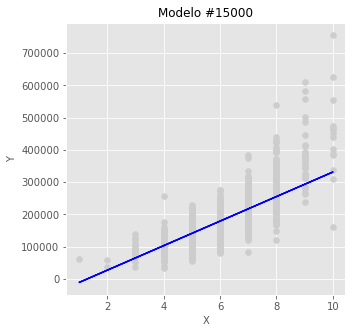

In [45]:
univ_linear_reg.model_plot(m1_modelos, 3000)

## Entrenando modelos de regresión - con 1stFlrSF

In [ ]:
m2 = univ_linear_reg(train_1stFlrSF, 
                     train_SalePrice, 
                     1000001,100000,0.000001)
m2_modelos, m2_errores = m2.trained_models()   

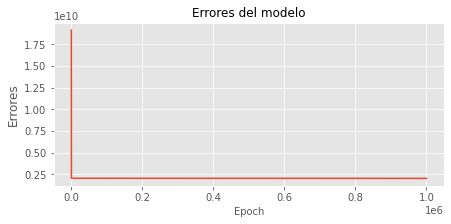

In [105]:
univ_linear_reg.error_plot(m2_errores)

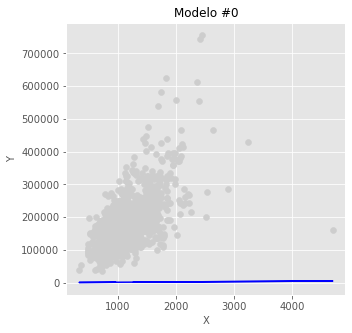

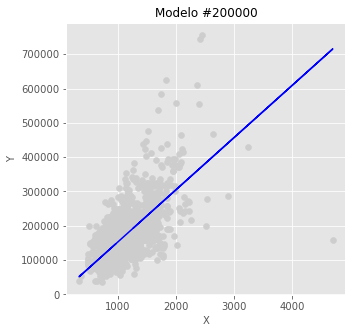

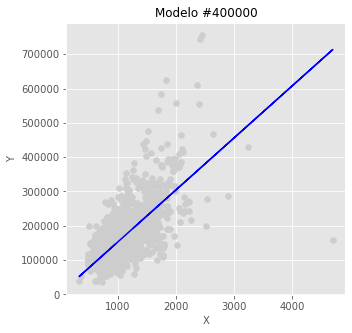

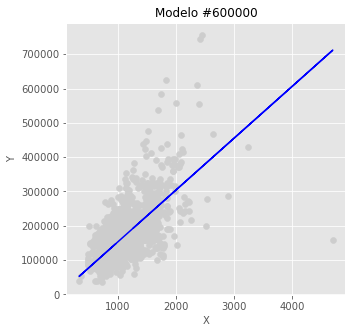

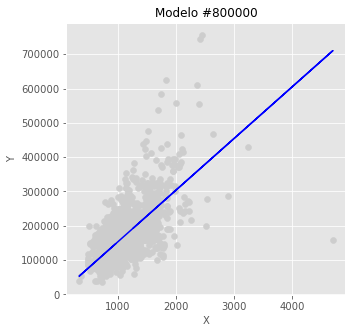

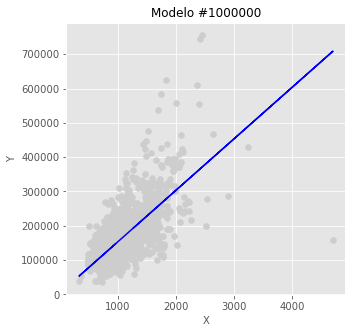

In [106]:
univ_linear_reg.model_plot(m2_modelos, 200000)

## Predicciones modelo propio vs SK-Learn

### Entrenamiento con Scikit Learn

In [51]:
skm1 = LinearRegression().fit(train_OverallQual.reshape(-1,1), train_SalePrice.reshape(-1,1))
skm2 = LinearRegression().fit(train_1stFlrSF.reshape(-1,1), train_SalePrice.reshape(-1,1))

### Predicciones con modelo propio, Scikit Learn y Promedio

In [52]:
test_OverallQual = np.array(test['OverallQual'])
test_1stFlrSF = np.array(test['1stFlrSF'])

In [54]:
modelos_OverallQual = univ_linear_reg.model_comparative(m1, skm1, test_OverallQual)
modelos_1stFlrSF = univ_linear_reg.model_comparative(m2, skm2, test_1stFlrSF)

NameError: name 'm2' is not defined

## Comparando modelos 

- Modelo 1 - Modelo Propio
- Modelo 2 - Modelo Scikit Learn
- Modelo 3 - Modelo Promedio

In [53]:
univ_linear_reg.ploting_error_models(modelos_OverallQual)

NameError: name 'modelos_OverallQual' is not defined

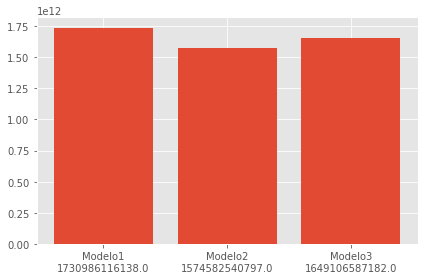

In [127]:
univ_linear_reg.ploting_error_models(modelos_1stFlrSF)

- **OverallQual**: todos los modelos tienen un error con el 20% de la data muy similar, pero la regresión creada para esta tarea es el modelo con con menor error  
- **1stFlrSF**: el mejor modelo es la regresión de scikit learn, con un error significativemente menor 